## 门控循环单元（GRU）

### 重置门和更新门

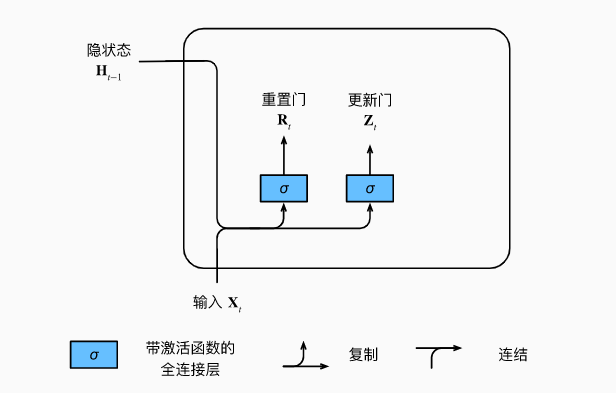

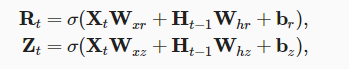

### 候选隐藏状态
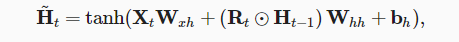
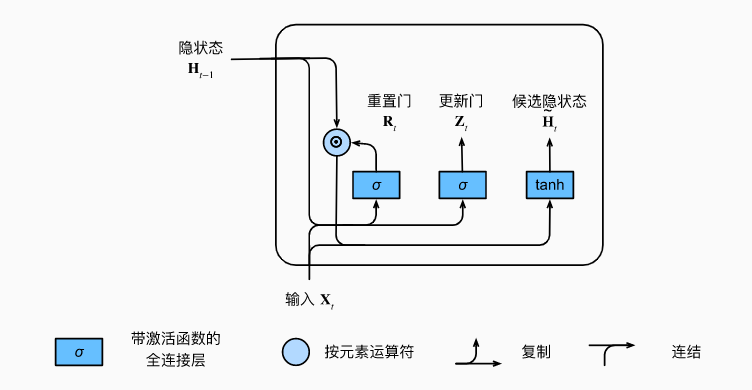

### 隐状态 
最终计算公式
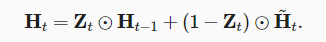
更新门作用：
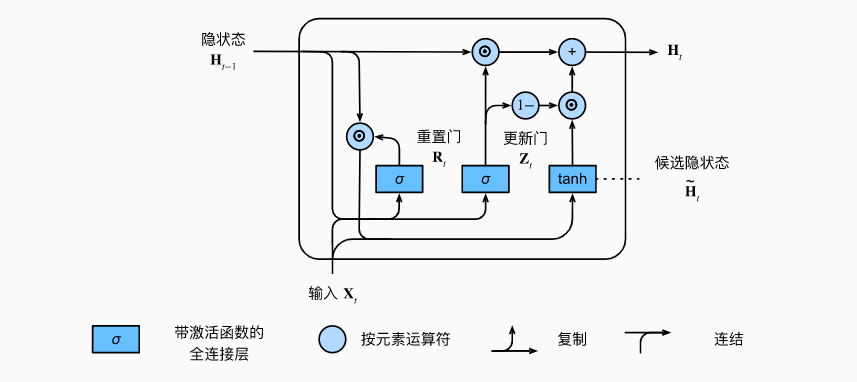

In [7]:
# GRU从零实现
# 导入数据

import torch
from torch import nn
import dltools

batch_size, num_steps = 32, 35
train_iter, vocab = dltools.load_data_time_machine(batch_size, num_steps)

In [9]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [10]:
# 定义模型
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

KeyboardInterrupt: 

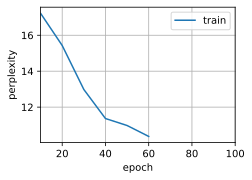

In [11]:
# 训练与预测：
vocab_size, num_hiddens, device = len(vocab), 256, dltools.try_gpu()
num_epochs, lr = 100, 1
model = dltools.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
dltools.train_ch8(model, train_iter, vocab, lr, num_epochs, device)


perplexity 7.8, 7122.4 tokens/sec on cpu
time traveller and the the the the the the the the the the the t
traveller and the the the the the the the the the the the t


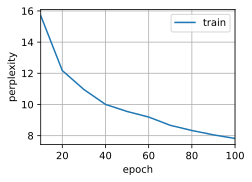

In [13]:
# 简洁版实现

num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = dltools.RNNModel(gru_layer, len(vocab))
model = model.to(device)
dltools.train_ch8(model, train_iter, vocab, lr, num_epochs, device)